# MELD Stratification Analysis on STARR-OMOP
Richard Yoo (rmyoo@stanford.edu)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prework" data-toc-modified-id="Prework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prework</a></span></li><li><span><a href="#Cohort-Construction" data-toc-modified-id="Cohort-Construction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cohort Construction</a></span><ul class="toc-item"><li><span><a href="#Select-Patients-with-Liver-Cirrhosis" data-toc-modified-id="Select-Patients-with-Liver-Cirrhosis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Select Patients with Liver Cirrhosis</a></span></li><li><span><a href="#Remove-Patients-without-Race-Information" data-toc-modified-id="Remove-Patients-without-Race-Information-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Remove Patients without Race Information</a></span></li><li><span><a href="#Remove-Patients-without-Gender-Information" data-toc-modified-id="Remove-Patients-without-Gender-Information-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Remove Patients without Gender Information</a></span></li><li><span><a href="#Filter-Encounters-by-Age" data-toc-modified-id="Filter-Encounters-by-Age-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Filter Encounters by Age</a></span></li><li><span><a href="#Filter-Encounters-after-Liver-Transplant" data-toc-modified-id="Filter-Encounters-after-Liver-Transplant-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Filter Encounters after Liver Transplant</a></span></li></ul></li><li><span><a href="#Outcomes-Assessment" data-toc-modified-id="Outcomes-Assessment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outcomes Assessment</a></span></li><li><span><a href="#MELD-Indicators" data-toc-modified-id="MELD-Indicators-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MELD Indicators</a></span><ul class="toc-item"><li><span><a href="#Dialysis-at-Least-Twice-in-the-Past-Week" data-toc-modified-id="Dialysis-at-Least-Twice-in-the-Past-Week-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dialysis at Least Twice in the Past Week</a></span></li><li><span><a href="#CVVHD-for->=-24-Hours-in-the-Past-Week" data-toc-modified-id="CVVHD-for->=-24-Hours-in-the-Past-Week-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CVVHD for &gt;= 24 Hours in the Past Week</a></span></li><li><span><a href="#Creatinine" data-toc-modified-id="Creatinine-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Creatinine</a></span></li><li><span><a href="#Bilirubin" data-toc-modified-id="Bilirubin-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Bilirubin</a></span></li><li><span><a href="#INR" data-toc-modified-id="INR-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>INR</a></span></li><li><span><a href="#Sodium" data-toc-modified-id="Sodium-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Sodium</a></span></li></ul></li><li><span><a href="#Compute-MELD" data-toc-modified-id="Compute-MELD-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compute MELD</a></span></li><li><span><a href="#Obtain-Cohort-Statistics" data-toc-modified-id="Obtain-Cohort-Statistics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Obtain Cohort Statistics</a></span></li><li><span><a href="#Survival-Analysis" data-toc-modified-id="Survival-Analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Survival Analysis</a></span><ul class="toc-item"><li><span><a href="#Create-Survival-Table" data-toc-modified-id="Create-Survival-Table-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Create Survival Table</a></span></li><li><span><a href="#Study-MELD-Concordance" data-toc-modified-id="Study-MELD-Concordance-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Study MELD Concordance</a></span></li><li><span><a href="#Observe-Negative-Events" data-toc-modified-id="Observe-Negative-Events-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Observe Negative Events</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Logistic Regression</a></span></li></ul></div>

In [1]:
import datetime
import lifelines
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import qgrid
import scipy.stats as stats
import statsmodels.api as sm
import swifter

from dateutil.relativedelta import relativedelta
from google.cloud import bigquery
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Prework

Below project setup assumes access to STARR-OMOP identified through Nero.

In [2]:
# Project setup.
user_id = os.getlogin()
nero_gcp_project = 'som-nero-phi-nigam-starr'
project_id = 'som-nero-phi-nigam-starr'
dataset_id = 'shahlab_omop_cdm5_subset_2021_09_29'
work_project_id = nero_gcp_project
death_dataset_id = 'death'

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/{}/.config/gcloud/application_default_credentials.json'.format(user_id)
os.environ['GCLOUD_PROJECT'] = nero_gcp_project

In [4]:
# Create client.
client = bigquery.Client(project=work_project_id)

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Cohort Construction

### Select Patients with Liver Cirrhosis

In [5]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Clinical Finding" AND
  standard_concept = "S" AND
  CONTAINS_SUBSTR(concept_name, 'liver') AND
  CONTAINS_SUBSTR(concept_name, 'cirrhosis')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Use standard concept [4064161 Cirrhosis of liver](https://athena.ohdsi.org/search-terms/terms/4064161) as entry point, and retrieve all descendant concepts.

In [6]:
def query_descendants(root_id):
    query = """ 
    SELECT 
      * 
    FROM
      `{project_id}.{dataset_id}.concept_relationship`
    WHERE 
      concept_id_1 = {root_id} AND
      relationship_id in ('Subsumes', 'Concept same_as from')
    """.format_map({'project_id': project_id,
                    'dataset_id': dataset_id,
                    'root_id': root_id})
    
    result = client.query(query).to_dataframe()
    return(result['concept_id_2'].tolist())

# Expects input to be an integer, and returns a list of integers.
def extract_all_descendants(start_id):
    unprocessed = [start_id]
    processed = []
    
    while len(unprocessed) > 0:
        root_id = unprocessed.pop(0)
        
        descendants = query_descendants(root_id)
        
        processed.append(root_id)
        unprocessed.extend(descendants)
        
    return processed

In [7]:
cirrhosis_concept_id = ", ".join([str(i) for i in extract_all_descendants(4064161)])
cirrhosis_concept_id

'4064161, 4055210, 194692, 4071022, 4059284, 4300060, 42539566, 4340946, 37110890, 4098583, 4184779, 43531723, 4159158, 37396401, 4046016, 4294539, 44800333, 4232955, 4340394, 4153294, 4048083, 444246, 4340948, 4203601, 3185452, 4048057, 4049419, 192675, 4163687, 4313567, 44800333, 4058681, 37396157, 45772057, 4143008, 44783142, 4304584, 4268006, 4340393, 44805713, 4049282, 444246, 40317575, 4050640, 4252074, 4050640, 40393766, 3183806, 40438004, 40393792, 40393775, 4342776, 40393793, 4135822, 4059289, 4292401, 4003673, 37111265, 37117933, 37111266, 196463, 4058680, 4144116, 4141628, 4055209, 4148254, 4059287, 4055212, 4059285, 4340392, 4059288, 4055212, 4140536, 4053079, 4141628, 37399445, 4046123, 4058682, 4058682, 4292401'

Verify concepts.

In [8]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({cirrhosis_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cirrhosis_concept_id': cirrhosis_concept_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Query for cirrhosis occurences.

In [9]:
query = """ 
SELECT 
  person_id, condition_concept_id, condition_start_DATE, condition_end_DATE
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  condition_concept_id IN ({cirrhosis_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cirrhosis_concept_id': cirrhosis_concept_id})

cirrhosis_result = client.query(query).to_dataframe()
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE
0,1253558,4046123,2021-07-30,None
1,3302245,4046123,2019-05-02,None
2,616166,43531723,2014-12-14,2014-12-14
3,2261894,4046123,2016-11-17,None
4,1381993,4046123,2017-09-14,None
...,...,...,...,...
288867,1253558,192675,2017-12-15,None
288868,709136,192675,2018-10-30,None
288869,3053627,192675,2014-05-29,None
288870,3743038,192675,2014-06-01,None


In [10]:
cirrhosis_result.groupby('condition_concept_id').count()

,person_id,condition_start_DATE,condition_end_DATE
condition_concept_id,,,
192675,12396,12396,71
194692,88514,88514,2347
196463,48409,48409,1599
4046123,1013,1013,5
4064161,111046,111046,3170
4135822,27191,27191,532
4340394,98,98,0
4340948,67,67,1
43531723,138,138,136


### Remove Patients without Race Information

In [11]:
cohort_list = ", ".join(cirrhosis_result['person_id'].unique().astype(str))

In [12]:
query = """ 
SELECT 
  person_id, gender_concept_id, birth_DATETIME, ethnicity_concept_id, race_concept_id
FROM
  `{project_id}.{dataset_id}.person`
WHERE
  person_id IN ({cohort_list})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list})

demography_result = client.query(query).to_dataframe()
demography_result

,person_id,gender_concept_id,birth_DATETIME,ethnicity_concept_id,race_concept_id
0,4291171,0,1974-09-25,38003564,8527
1,580689,8532,1944-07-12,0,2000039205
2,848497,8532,1950-08-02,0,0
3,2328444,8532,1980-12-11,0,0
4,4505571,8532,1986-07-25,0,0
...,...,...,...,...,...
16725,457998,8507,1940-08-20,38003564,8515
16726,1752447,8507,1968-06-07,38003564,2000039205
16727,966043,8507,1953-05-06,38003564,8527
16728,694646,8507,1947-10-05,38003564,8527


In [13]:
# Cast hispanic ethnicity as race.
demography_result.loc[demography_result['ethnicity_concept_id'] == 38003563, 'race_concept_id'] = 38003563

In [14]:
demography_result.groupby('race_concept_id').count()

,person_id,gender_concept_id,birth_DATETIME,ethnicity_concept_id
race_concept_id,,,,
0,183,183,183,183
8515,2253,2253,2253,2253
8516,565,565,565,565
8527,7067,7067,7067,7067
8557,148,148,148,148
8657,89,89,89,89
38003563,3631,3631,3631,3631
2000039200,7,7,7,7
2000039205,1075,1075,1075,1075


In [15]:
# Join.
cirrhosis_result = pd.merge(cirrhosis_result,
                            demography_result[['person_id', 'gender_concept_id', 'birth_DATETIME', 'race_concept_id']],
                            on='person_id', how='left')

In [16]:
race_map = {
    8515: 'Asian', 
    8516: 'Black', 
    8527: 'White', 
    8557: 'Pacific Islander', 
    8657: 'Native American', 
    38003563: 'Hispanic'
}

In [17]:
# Drop entries with 'race_concept_id' not in race_map.
cirrhosis_result = cirrhosis_result[cirrhosis_result['race_concept_id'].isin(race_map.keys())]

In [18]:
cirrhosis_result.groupby('race_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME
race_concept_id,,,,,,
8515,48472,48472,48472,921,48472,48472
8516,8178,8178,8178,242,8178,8178
8527,115178,115178,115178,3258,115178,115178
8557,1943,1943,1943,48,1943,1943
8657,1989,1989,1989,53,1989,1989
38003563,85079,85079,85079,1952,85079,85079


In [19]:
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id
0,1253558,4046123,2021-07-30,None,8532,1959-06-23,38003563
2,616166,43531723,2014-12-14,2014-12-14,8532,1945-04-19,8527
3,2261894,4046123,2016-11-17,None,8507,1978-10-07,8527
4,1381993,4046123,2017-09-14,None,8532,1961-04-07,8527
5,3090170,4340394,2020-02-25,None,8507,1996-07-04,38003563
...,...,...,...,...,...,...,...
288867,1253558,192675,2017-12-15,None,8532,1959-06-23,38003563
288868,709136,192675,2018-10-30,None,8532,1947-09-20,38003563
288869,3053627,192675,2014-05-29,None,8532,1995-12-27,8515
288870,3743038,192675,2014-06-01,None,8507,2012-03-14,38003563


### Remove Patients without Gender Information

In [20]:
gender_map = {
    8532: 'Female', 
    8507: 'Male', 
}

In [21]:
# Drop entries with 'gender_concept_id' not in gender_map.
cirrhosis_result = cirrhosis_result[cirrhosis_result['gender_concept_id'].isin(gender_map.keys())]

In [22]:
cirrhosis_result.groupby('gender_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,birth_DATETIME,race_concept_id
gender_concept_id,,,,,,
8507,136935,136935,136935,3632,136935,136935
8532,123899,123899,123899,2842,123899,123899


In [23]:
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id
0,1253558,4046123,2021-07-30,None,8532,1959-06-23,38003563
2,616166,43531723,2014-12-14,2014-12-14,8532,1945-04-19,8527
3,2261894,4046123,2016-11-17,None,8507,1978-10-07,8527
4,1381993,4046123,2017-09-14,None,8532,1961-04-07,8527
5,3090170,4340394,2020-02-25,None,8507,1996-07-04,38003563
...,...,...,...,...,...,...,...
288867,1253558,192675,2017-12-15,None,8532,1959-06-23,38003563
288868,709136,192675,2018-10-30,None,8532,1947-09-20,38003563
288869,3053627,192675,2014-05-29,None,8532,1995-12-27,8515
288870,3743038,192675,2014-06-01,None,8507,2012-03-14,38003563


### Filter Encounters by Age

In [24]:
def compute_age(condition_start_DATE, birth_DATETIME):
    return relativedelta(condition_start_DATE, birth_DATETIME).years

cirrhosis_result['age_years'] = cirrhosis_result.swifter.progress_bar(True).apply(
    lambda row: compute_age(row['condition_start_DATE'], row['birth_DATETIME']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_3849164/2803120817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cirrhosis_result['age_years'] = cirrhosis_result.swifter.progress_bar(True).apply(


In [25]:
def age_12_or_older(age_years):
    if age_years >= 12:
        return True
    return False    

select_mask = cirrhosis_result.swifter.progress_bar(True).apply(
    lambda row: age_12_or_older(row['age_years']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [26]:
select_mask.value_counts()

True     258108
False      2726
dtype: int64

In [27]:
# Drop encounters that are younger than 12.
cirrhosis_result = cirrhosis_result[select_mask]

In [28]:
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years
0,1253558,4046123,2021-07-30,None,8532,1959-06-23,38003563,62
2,616166,43531723,2014-12-14,2014-12-14,8532,1945-04-19,8527,69
3,2261894,4046123,2016-11-17,None,8507,1978-10-07,8527,38
4,1381993,4046123,2017-09-14,None,8532,1961-04-07,8527,56
5,3090170,4340394,2020-02-25,None,8507,1996-07-04,38003563,23
...,...,...,...,...,...,...,...,...
288866,598944,192675,2010-03-30,None,8532,1944-07-19,8527,65
288867,1253558,192675,2017-12-15,None,8532,1959-06-23,38003563,58
288868,709136,192675,2018-10-30,None,8532,1947-09-20,38003563,71
288869,3053627,192675,2014-05-29,None,8532,1995-12-27,8515,18


### Filter Encounters after Liver Transplant

In [29]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Procedure" AND
  standard_concept = "S" AND
  CONTAINS_SUBSTR(concept_name, 'liver') AND
  CONTAINS_SUBSTR(concept_name, 'transplant')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Use standard concept [4076862 Transplantation of liver](https://athena.ohdsi.org/search-terms/terms/4076862) as entry point, and retrieve all descendant concepts.

In [30]:
liver_transplant_concept_id = ", ".join([str(i) for i in extract_all_descendants(4076862)])
liver_transplant_concept_id

'4076862, 44510215, 2721087, 4067458, 4101838, 4099299, 2003166, 44809584, 44789810, 40314618, 4068633, 4067459, 4139049, 40444226'

Verify concepts.

In [31]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({liver_transplant_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'liver_transplant_concept_id': liver_transplant_concept_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Query for liver transplant occurences.

In [32]:
cohort_list = ", ".join(cirrhosis_result['person_id'].unique().astype(str))

In [33]:
query = """ 
SELECT 
  *
FROM
  `{project_id}.{dataset_id}.procedure_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  procedure_concept_id IN ({liver_transplant_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'liver_transplant_concept_id': liver_transplant_concept_id})

liver_transplant_result = client.query(query).to_dataframe()
liver_transplant_result

,procedure_occurrence_id,person_id,procedure_concept_id,procedure_DATE,procedure_DATETIME,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,trace_id,unit_id,load_table_id
0,34257908,3188565,2003166,2014-07-02,2014-07-02,44786630,0,1,165402.0,NaN,NaN,50.59,2003166,None,"{""hsp_account_id"":70061819}",procedure.rule.2.lpch_hsp_acct_px_list,lpch_hsp_acct_px_list
1,30910809,1304237,2003166,2013-12-04,2013-12-04,44786630,0,1,227324.0,NaN,NaN,50.59,2003166,None,"{""hsp_account_id"":54682288}",procedure.rule.2.shc_hsp_acct_px_list,shc_hsp_acct_px_list
2,39394281,1505993,2003166,2015-03-04,2015-03-04,44786630,0,1,NaN,70198967.0,NaN,50.59,2003166,None,"{""hsp_account_id"":56367059}",None,shc_hsp_acct_px_list
3,27930186,597289,2003166,2013-05-12,2013-05-12,44786630,0,1,233891.0,NaN,NaN,50.59,2003166,None,"{""hsp_account_id"":54008486}",procedure.rule.2.shc_hsp_acct_px_list,shc_hsp_acct_px_list
4,13178636,756120,2003166,2009-10-24,2009-10-24,44786630,0,1,NaN,36630266.0,NaN,50.59,36906430,None,"{""hsp_account_id"":50177677}",None,shc_hsp_acct_px_list
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,38794128,2684315,2003166,2015-02-05,2015-02-05,44786630,0,1,NaN,68868821.0,NaN,50.59,2003166,None,"{""hsp_account_id"":56203074}",None,shc_hsp_acct_px_list
966,41637252,968340,2003166,2015-06-05,2015-06-05,44786630,0,1,233891.0,NaN,NaN,50.59,2003166,None,"{""hsp_account_id"":56715291}",procedure.rule.2.shc_hsp_acct_px_list,shc_hsp_acct_px_list
967,14607486,1480511,2003166,2010-03-16,2010-03-16,44786630,0,1,227323.0,NaN,NaN,50.59,2003166,None,"{""hsp_account_id"":50572849}",procedure.rule.2.shc_hsp_acct_px_list,shc_hsp_acct_px_list
968,40345558,775279,2003166,2015-04-13,2015-04-13,44786630,0,1,NaN,71793113.0,NaN,50.59,2003166,None,"{""hsp_account_id"":56560376}",None,shc_hsp_acct_px_list


In [34]:
def before_liver_transplant(person_id, condition_start_DATE):
    match = liver_transplant_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['procedure_DATE'] <= condition_start_DATE:
                return False      
    return True

select_mask = cirrhosis_result.swifter.progress_bar(True).apply(
    lambda row: before_liver_transplant(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [35]:
select_mask.value_counts()

True     252271
False      5837
dtype: int64

In [36]:
# Drop conditions that happened after liver transplant.
cirrhosis_result = cirrhosis_result[select_mask]

In [37]:
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years
0,1253558,4046123,2021-07-30,None,8532,1959-06-23,38003563,62
2,616166,43531723,2014-12-14,2014-12-14,8532,1945-04-19,8527,69
3,2261894,4046123,2016-11-17,None,8507,1978-10-07,8527,38
4,1381993,4046123,2017-09-14,None,8532,1961-04-07,8527,56
5,3090170,4340394,2020-02-25,None,8507,1996-07-04,38003563,23
...,...,...,...,...,...,...,...,...
288866,598944,192675,2010-03-30,None,8532,1944-07-19,8527,65
288867,1253558,192675,2017-12-15,None,8532,1959-06-23,38003563,58
288868,709136,192675,2018-10-30,None,8532,1947-09-20,38003563,71
288869,3053627,192675,2014-05-29,None,8532,1995-12-27,8515,18


Redefine cohort.

In [38]:
cohort_list = ", ".join(cirrhosis_result['person_id'].unique().astype(str))

## Outcomes Assessment

`death_ssdmf` table contains death records identified from both SSDMF and SHC.

In [39]:
query = """ 
SELECT 
  *
FROM
  `{project_id}.{death_dataset_id}.death_ssdmf`
WHERE 
  person_id IN ({cohort_list})
""".format_map({'project_id': project_id,
                'death_dataset_id': death_dataset_id,
                'cohort_list': cohort_list})

death_result = client.query(query).to_dataframe()
death_result

,person_id,death_DATE
0,1228114,2021-03-02
1,838353,2021-03-02
2,1108425,2019-10-09
3,778918,2015-07-27
4,254558,2012-10-10
...,...,...
321,451796,2018-05-11
322,510593,2012-01-20
323,517326,2012-01-20
324,1029067,2012-01-20


## MELD Indicators

### Dialysis at Least Twice in the Past Week

In [40]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Procedure" AND
  standard_concept = "S" AND
  CONTAINS_SUBSTR(concept_name, 'renal') AND
  CONTAINS_SUBSTR(concept_name, 'dialysis')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Use standard concept [4146536 Renal dialysis](https://athena.ohdsi.org/search-terms/terms/4146536) as entry point, and retrieve all descendant concepts.

In [41]:
dialysis_concept_id = ", ".join([str(i) for i in extract_all_descendants(4146536)])
dialysis_concept_id

'4146536, 4120120, 37018292, 4121921, 4324124, 3171077, 4050864, 4080241, 40664745, 4286500, 4051326, 4195714, 46270933, 4049845, 44783963, 4238836, 4146649, 40664693, 4140589, 4002872, 46273700, 46270524, 40513647, 4050863, 4050863, 4052537, 40313129, 764695, 4080171, 4032775, 4195534, 4080169, 4247794, 40313136, 2721482, 4080172, 4031315, 4139443, 4020892, 4323627, 4030834, 4021976, 4049845, 37396069, 4050865, 46270935, 4052537, 4050862, 4051327, 2721479, 4052538, 46270932, 46270934, 4050866, 4051328, 4050866, 4051329, 42897969, 4051328, 4050866, 4051329, 42897969, 4049844, 4051330, 4050866, 42897969, 4052538, 46270932, 46270934, 4050866, 4049844, 4051330, 4050866, 42897969, 4050867, 4049846, 4050867, 4050867, 4049846, 4049846, 4050867, 4050867, 4049846, 4049846, 4050867, 4049846, 4050867, 4049846, 4050867, 4049846, 4050867, 4049846, 4050867, 4049846'

Verify concepts.

In [42]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({dialysis_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'dialysis_concept_id': dialysis_concept_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Query dialisys instances.

In [43]:
query = """ 
SELECT 
  *
FROM
  `{project_id}.{dataset_id}.procedure_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  procedure_concept_id IN ({dialysis_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'dialysis_concept_id': dialysis_concept_id})

dialysis_result = client.query(query).to_dataframe()
dialysis_result

,procedure_occurrence_id,person_id,procedure_concept_id,procedure_DATE,procedure_DATETIME,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,trace_id,unit_id,load_table_id
0,28445681,1267519,4120120,2013-06-17,2013-06-17,44786630,0,1,273585.0,54462325.0,NaN,HEMODIALYSIS,2000031590,None,"{""order_proc_id"":421165082}",procedure.rule.1.shc_order_proc.descr,shc_order_proc
1,16407541,1059713,4120120,2010-09-07,2010-09-07,44786630,0,1,238217.0,39699443.0,NaN,HEMODIALYSIS,2000031590,None,"{""order_proc_id"":371334634}",procedure.rule.1.shc_order_proc.descr,shc_order_proc
2,32694799,1403542,4120120,2014-04-04,2014-04-04,44786630,0,1,273372.0,60184381.0,NaN,HEMODIALYSIS,2000031590,None,"{""order_proc_id"":437031707}",procedure.rule.1.shc_order_proc.descr,shc_order_proc
3,115326715,4101094,4120120,2020-08-02,2020-08-02,44786630,0,1,284524.0,160653926.0,NaN,HEMODIALYSIS,2000031590,None,"{""order_proc_id"":674915400}",procedure.rule.1.shc_order_proc.descr,shc_order_proc
4,44715558,381669,4120120,2015-10-10,2015-10-10,44786630,0,1,246891.0,78197343.0,NaN,HEMODIALYSIS,2000031590,None,"{""order_proc_id"":475589165}",procedure.rule.1.shc_order_proc.descr,shc_order_proc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15480,14847722,871263,4120120,2010-04-07,2010-04-07,44786630,0,1,NaN,38436909.0,NaN,39.95,2002282,None,"{""hsp_account_id"":50627103}",None,shc_hsp_acct_px_list
15481,34651448,686125,4120120,2014-07-23,2014-07-23,44786630,0,1,293615.0,NaN,NaN,39.95,2002282,None,"{""hsp_account_id"":55531790}",procedure.rule.2.shc_hsp_acct_px_list,shc_hsp_acct_px_list
15482,20212491,1991805,4120120,2011-09-19,2011-09-19,44786630,0,1,NaN,44271518.0,NaN,39.95,36915866,None,"{""hsp_account_id"":52073322}",None,shc_hsp_acct_px_list
15483,13227215,176777,4120120,2009-10-29,2009-10-29,44786630,0,1,NaN,36778607.0,NaN,39.95,36915866,None,"{""hsp_account_id"":50123037}",None,shc_hsp_acct_px_list


In [44]:
dialysis_result.groupby('procedure_concept_id').count()

,procedure_occurrence_id,person_id,procedure_DATE,procedure_DATETIME,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,trace_id,unit_id,load_table_id
procedure_concept_id,,,,,,,,,,,,,,,,
4120120,15348,15348,15348,15348,15348,15348,15348,13237,14136,0,15348,15348,0,15348,13240,15348
4247794,2,2,2,2,2,2,2,1,2,0,2,2,0,2,2,2
4324124,72,72,72,72,72,72,72,24,48,0,72,72,0,72,24,72
37018292,61,61,61,61,61,61,61,61,61,0,61,61,0,61,61,61
42897969,2,2,2,2,2,2,2,1,1,0,2,2,0,2,1,2


### CVVHD for >= 24 Hours in the Past Week

Use standard concept [4051330 Continuous venovenous hemofiltration](https://athena.ohdsi.org/search-terms/terms/4051330) as entry point, and retrieve all descendant concepts.

In [45]:
cvvhd_concept_id = ", ".join([str(i) for i in extract_all_descendants(4051330)])
cvvhd_concept_id

'4051330, 4049846'

In [46]:
query = """ 
SELECT 
  *
FROM
  `{project_id}.{dataset_id}.procedure_occurrence`
WHERE
    procedure_concept_id IN ({cvvhd_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cvvhd_concept_id': cvvhd_concept_id})

cvvhd_result = client.query(query).to_dataframe()
cvvhd_result

,procedure_occurrence_id,person_id,procedure_concept_id,procedure_DATE,procedure_DATETIME,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,trace_id,unit_id,load_table_id


### Creatinine

In [47]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Lab Test" AND
  CONTAINS_SUBSTR(concept_name, 'creatinine') AND
  CONTAINS_SUBSTR(concept_name, 'serum')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Select below concept IDs for creatinine:
* [3051825, 
Creatinine [Mass/volume] in Blood](https://athena.ohdsi.org/search-terms/terms/3051825)
* [3016723, 
Creatinine [Mass/volume] in Serum or Plasma](https://athena.ohdsi.org/search-terms/terms/3016723)
* [46235076, Creatinine [Moles/volume] in Serum, Plasma or Blood](https://athena.ohdsi.org/search-terms/terms/46235076)
* [40762887, 
Creatinine [Moles/volume] in Blood](https://athena.ohdsi.org/search-terms/terms/40762887)
* [3020564, Creatinine [Moles/volume] in Serum or Plasma](https://athena.ohdsi.org/search-terms/terms/3020564)
* [3032033, Creatinine [Mass or Moles/volume] in Serum or Plasma](https://athena.ohdsi.org/search-terms/terms/3032033)

In [48]:
creatinine_concept_id = "3051825, 3016723, 46235076, 40762887, 3020564, 3032033"

In [49]:
query = """
SELECT
  person_id, measurement_concept_id, measurement_DATE, measurement_DATETIME, unit_source_value, value_source_value
FROM
  {project_id}.{dataset_id}.measurement
WHERE
  person_id IN ({cohort_list}) AND
  measurement_concept_id IN ({creatinine_concept_id}) AND
  unit_source_value != "None" AND
  value_source_value != "None"
""".format_map({'cohort_list': cohort_list,
                'project_id': project_id,
                'dataset_id': dataset_id,
                'creatinine_concept_id': creatinine_concept_id})

creatinine_result = client.query(query).to_dataframe()
creatinine_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
0,793005,3016723,2019-05-10,2019-05-10 09:19:00,mg/dl,0.87
1,582702,3016723,2017-10-05,2017-10-05 08:56:00,mg/dL,0.45
2,1458837,3016723,2017-12-31,2017-12-31 05:37:00,mg/dL,0.45
3,206756,3016723,2013-11-08,2013-11-08 14:45:00,mg/dL,5.8
4,878222,3016723,2020-11-05,2020-11-05 07:02:00,mg/dL,12.99
...,...,...,...,...,...,...
512739,1891305,3016723,2021-01-28,2021-01-28 05:03:00,mg/dL,0.84
512740,436952,3016723,2019-06-20,2019-06-20 08:17:00,mg/dL,0.84
512741,865004,3016723,2018-12-07,2018-12-07 15:42:00,mg/dL,0.84
512742,533429,3016723,2016-12-12,2016-12-12 04:49:00,mg/dL,0.84


In [50]:
creatinine_result.groupby('measurement_concept_id').count()

,person_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
measurement_concept_id,,,,,
3016723,512744,512744,512744,512744,512744


When there are multiple measurements on the same day, use the first measurement.

In [51]:
creatinine_result = creatinine_result.sort_values(by=['person_id', 'measurement_DATETIME']).groupby(['person_id', 'measurement_DATE']).head(1)
creatinine_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
322538,55592,3016723,2014-03-28,2014-03-28 18:50:00,mg/dL,0.9
358881,55592,3016723,2015-06-13,2015-06-13 16:17:00,mg/dL,1.0
369561,55592,3016723,2015-06-14,2015-06-14 06:43:00,mg/dL,1.1
321792,55592,3016723,2015-06-15,2015-06-15 06:18:00,mg/dL,0.9
390614,55592,3016723,2015-12-28,2015-12-28 14:56:00,mg/dL,1.2
...,...,...,...,...,...,...
72384,4506230,3016723,2021-09-13,2021-09-13 03:02:00,mg/dL,0.58
218794,4506230,3016723,2021-09-14,2021-09-14 06:06:00,mg/dL,0.64
42541,4506230,3016723,2021-09-15,2021-09-15 05:40:00,mg/dL,0.66
85130,4506230,3016723,2021-09-16,2021-09-16 05:53:00,mg/dL,0.66


In [52]:
# Cast measurement values to numeric.
creatinine_result['value_source_value'] = pd.to_numeric(creatinine_result['value_source_value'], errors='coerce')
creatinine_result = creatinine_result.dropna(subset=['value_source_value'])

In [53]:
# Strip empty characters in unit_source_value.
creatinine_result['unit_source_value'] = creatinine_result['unit_source_value'].str.strip()

/tmp/ipykernel_3849164/2854414786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creatinine_result['unit_source_value'] = creatinine_result['unit_source_value'].str.strip()


Check measurement units.

In [54]:
creatinine_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,value_source_value
unit_source_value,,,,,
MG/DL,474,474,474,474,474
mg/dL,403206,403206,403206,403206,403206
mg/dl,583,583,583,583,583
umol/L,18,18,18,18,18


In [55]:
creatinine_result.loc[creatinine_result['unit_source_value'].str.lower() == "mg/dl", 'unit_source_value'] = "mg/dL"

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [56]:
# Convert umol/L to mg/dL: http://www.scymed.com/en/smnxps/psxdf212_c.htm
creatinine_result.loc[creatinine_result['unit_source_value'] == "umol/L", 'value_source_value'] /= 88.42
creatinine_result.loc[creatinine_result['unit_source_value'] == "umol/L", 'unit_source_value'] = "mg/dL"

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [57]:
creatinine_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,value_source_value
unit_source_value,,,,,
mg/dL,404281,404281,404281,404281,404281


In [58]:
creatinine_result['value_source_value'].describe()

count    404281.000000
mean          1.486124
std           1.392505
min           0.060000
25%           0.800000
50%           1.080000
75%           1.550000
max          86.000000
Name: value_source_value, dtype: float64

(array([3.85595e+05, 1.62070e+04, 2.18100e+03, 2.52000e+02, 3.70000e+01,
        2.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([6.0000e-02, 4.3570e+00, 8.6540e+00, 1.2951e+01, 1.7248e+01,
        2.1545e+01, 2.5842e+01, 3.0139e+01, 3.4436e+01, 3.8733e+01,
        4.3030e+01, 4.7327e+01, 5.1624e+01, 5.5921e+01, 6.0218e+01,
        6.4515e+01, 6.8812e+01, 7.3109e+01, 7.7406e+01, 8.1703e+01,
        8.6000e+01]),
 <BarContainer object of 20 artists>)

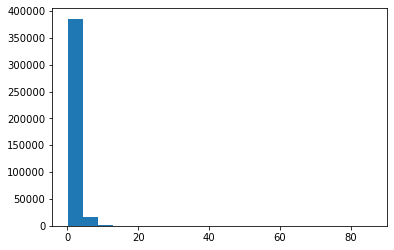

In [59]:
plt.hist(creatinine_result['value_source_value'], bins=20)

### Bilirubin

In [60]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Lab Test" AND
  CONTAINS_SUBSTR(concept_name, 'bilirubin') AND
  CONTAINS_SUBSTR(concept_name, 'serum')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Focusing on total bilirubin, select below concept IDs:
* [3032945, Bilirubin.total [Mass or Moles/volume] in Serum or Plasma](https://athena.ohdsi.org/search-terms/terms/3032945)
* [3006140, Bilirubin.total [Moles/volume] in Serum or Plasma](https://athena.ohdsi.org/search-terms/terms/3006140)
* [46235782, Bilirubin.total [Moles/volume] in Serum, Plasma or Blood](https://athena.ohdsi.org/search-terms/terms/46235782)
* [3024128, Bilirubin.total [Mass/volume] in Serum or Plasma](https://athena.ohdsi.org/search-terms/terms/3024128)

Drop concept ID 3045524 since it is difficult to distinguish direct vs. total.

In [61]:
bilirubin_concept_id = "3032945, 3006140, 46235782, 3024128"

In [62]:
query = """
SELECT
  person_id, measurement_concept_id, measurement_DATE, measurement_DATETIME, unit_source_value, value_source_value
FROM
  {project_id}.{dataset_id}.measurement
WHERE
  person_id IN ({cohort_list}) AND
  measurement_concept_id IN ({bilirubin_concept_id}) AND
  unit_source_value != "None" AND
  value_source_value != "None"
""".format_map({'cohort_list': cohort_list,
                'project_id': project_id,
                'dataset_id': dataset_id,
                'bilirubin_concept_id': bilirubin_concept_id})

bilirubin_result = client.query(query).to_dataframe()
bilirubin_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
0,2659536,3024128,2017-12-03,2017-12-03 08:59:00,mg/dL,9.0
1,2750885,3024128,2007-07-01,2007-07-01 23:15:00,mg/dL,24.0
2,1831587,3024128,2019-06-06,2019-06-06 06:06:00,mg/dL,10.1
3,917545,3024128,2019-10-31,2019-10-31 04:43:00,mg/dL,6.9
4,854090,3024128,2013-04-04,2013-04-04 09:25:00,mg/dL,7.9
...,...,...,...,...,...,...
413830,1162152,3024128,2010-02-25,2010-02-25 08:29:00,mg/dL,<0.5
413831,565922,3024128,2010-04-02,2010-04-02 06:20:00,mg/dL,<0.5
413832,466607,3024128,2009-03-09,2009-03-09 09:09:00,mg/dL,<0.5
413833,1727532,3024128,2012-01-29,2012-01-29 09:35:00,mg/dL,<0.5


In [63]:
bilirubin_result.groupby('measurement_concept_id').count()

,person_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
measurement_concept_id,,,,,
3024128,413835,413835,413835,413835,413835


When there are multiple measurements on the same day, use the first measurement.

In [64]:
bilirubin_result = bilirubin_result.sort_values(by=['person_id', 'measurement_DATETIME']).groupby(['person_id', 'measurement_DATE']).head(1)
bilirubin_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
156504,55592,3024128,2014-03-28,2014-03-28 18:50:00,mg/dL,0.5
183816,55592,3024128,2015-06-13,2015-06-13 16:17:00,mg/dL,0.6
145534,55592,3024128,2015-12-28,2015-12-28 14:56:00,mg/dL,0.5
218679,56835,3024128,2014-05-28,2014-05-28 15:24:00,mg/dL,0.7
153534,57017,3024128,2016-04-08,2016-04-08 15:22:00,mg/dL,0.5
...,...,...,...,...,...,...
76760,4506230,3024128,2021-09-13,2021-09-13 03:02:00,mg/dL,9.1
30607,4506230,3024128,2021-09-14,2021-09-14 06:06:00,mg/dL,8.8
23975,4506230,3024128,2021-09-15,2021-09-15 05:40:00,mg/dL,8.8
75814,4506230,3024128,2021-09-16,2021-09-16 05:53:00,mg/dL,7.9


In [65]:
# Cast measurement values to numeric.
bilirubin_result['value_source_value'] = pd.to_numeric(bilirubin_result['value_source_value'], errors='coerce')
bilirubin_result = bilirubin_result.dropna(subset=['value_source_value'])

In [66]:
# Strip empty characcters in unit_source_value.
bilirubin_result['unit_source_value'] = bilirubin_result['unit_source_value'].str.strip()

/tmp/ipykernel_3849164/651175246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bilirubin_result['unit_source_value'] = bilirubin_result['unit_source_value'].str.strip()


Check measurement units.

In [67]:
bilirubin_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,value_source_value
unit_source_value,,,,,
MG/DL,394,394,394,394,394
mg/dL,339172,339172,339172,339172,339172
mg/dL (See scan or EMR data for detail),589,589,589,589,589
mg/dl,492,492,492,492,492


In [68]:
# Normalize everything to mg/dL.
bilirubin_result['unit_source_value'] = "mg/dL"

/tmp/ipykernel_3849164/583357193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bilirubin_result['unit_source_value'] = "mg/dL"


In [69]:
bilirubin_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,value_source_value
unit_source_value,,,,,
mg/dL,340647,340647,340647,340647,340647


In [70]:
bilirubin_result['value_source_value'].describe()

count    340647.000000
mean          2.613538
std           5.208424
min           0.000000
25%           0.500000
50%           0.900000
75%           2.000000
max         142.000000
Name: value_source_value, dtype: float64

(array([3.12485e+05, 1.45690e+04, 6.01900e+03, 3.66600e+03, 2.43300e+03,
        1.08900e+03, 2.94000e+02, 7.20000e+01, 1.30000e+01, 4.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,   7.1,  14.2,  21.3,  28.4,  35.5,  42.6,  49.7,  56.8,
         63.9,  71. ,  78.1,  85.2,  92.3,  99.4, 106.5, 113.6, 120.7,
        127.8, 134.9, 142. ]),
 <BarContainer object of 20 artists>)

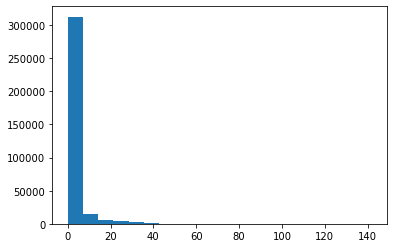

In [71]:
plt.hist(bilirubin_result['value_source_value'], bins=20)

### INR

In [72]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Lab Test" AND
  CONTAINS_SUBSTR(concept_name, 'INR')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [73]:
inr_concept_id = "3042605, 3039326, 3051593, 3022217, 3032080"

In [74]:
query = """
SELECT
  person_id, measurement_concept_id, measurement_DATE, measurement_DATETIME, unit_source_value, value_source_value
FROM
  {project_id}.{dataset_id}.measurement
WHERE
  person_id IN ({cohort_list}) AND
  measurement_concept_id IN ({inr_concept_id}) AND
  unit_source_value != "None" AND
  value_source_value != "None"
""".format_map({'cohort_list': cohort_list,
                'project_id': project_id,
                'dataset_id': dataset_id,
                'inr_concept_id': inr_concept_id})

inr_result = client.query(query).to_dataframe()
inr_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
0,1619062,3022217,2009-12-13,2009-12-13 07:55:00,INR,3.4
1,3225216,3022217,2013-06-10,2013-06-10 04:25:00,INR,3.3
2,714460,3022217,2008-02-26,2008-02-26 11:20:00,INR,5.8
3,1279658,3022217,2007-07-22,2007-07-22 05:31:00,INR,3.3
4,736090,3022217,2007-11-29,2007-11-29 05:30:00,INR,4.2
...,...,...,...,...,...,...
133275,1491502,3022217,2010-11-30,2010-11-30 06:30:00,INR,N/A
133276,797376,3022217,2011-12-06,2011-12-06 05:30:00,INR,N/A
133277,929820,3022217,2013-04-08,2013-04-08 15:55:00,INR,N/A
133278,107444,3022217,2011-04-29,2011-04-29 12:15:00,INR,N/A


In [75]:
inr_result.groupby('measurement_concept_id').count()

,person_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
measurement_concept_id,,,,,
3022217,129283,129283,129283,129283,129283
3032080,3997,3997,3997,3997,3997


When there are multiple measurements on the same day, use the first measurement.

In [76]:
inr_result = inr_result.sort_values(by=['person_id', 'measurement_DATETIME']).groupby(['person_id', 'measurement_DATE']).head(1)
inr_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
19529,55592,3022217,2014-03-28,2014-03-28 18:50:00,INR,1.1
128783,57017,3022217,2013-04-24,2013-04-24 14:45:00,INR,2.9
129252,57017,3022217,2013-05-14,2013-05-14 14:21:00,INR,2.9
535,57017,3022217,2014-01-21,2014-01-21 13:39:00,INR,4.4
1469,57017,3022217,2014-02-07,2014-02-07 13:29:00,INR,3.7
...,...,...,...,...,...,...
53857,4464693,3032080,2021-08-27,2021-08-27 09:47:00,INR,1.3
92179,4468655,3032080,2021-07-23,2021-07-23 05:28:00,INR,1.7
8101,4473789,3032080,2021-08-23,2021-08-23 08:18:00,INR,1.0
15282,4476877,3032080,2021-09-23,2021-09-23 06:17:00,INR,1.0


In [77]:
# Cast measurement values to numeric.
inr_result['value_source_value'] = pd.to_numeric(inr_result['value_source_value'], errors='coerce')
inr_result = inr_result.dropna(subset=['value_source_value'])

In [78]:
inr_result['value_source_value'].describe()

count    108300.000000
mean          1.624656
std           0.836458
min           0.700000
25%           1.200000
50%           1.400000
75%           1.800000
max         102.000000
Name: value_source_value, dtype: float64

(array([1.08019e+05, 2.56000e+02, 1.30000e+01, 5.00000e+00, 2.00000e+00,
        0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0.7  ,   5.765,  10.83 ,  15.895,  20.96 ,  26.025,  31.09 ,
         36.155,  41.22 ,  46.285,  51.35 ,  56.415,  61.48 ,  66.545,
         71.61 ,  76.675,  81.74 ,  86.805,  91.87 ,  96.935, 102.   ]),
 <BarContainer object of 20 artists>)

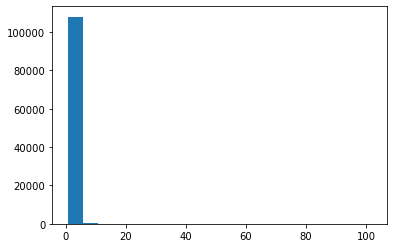

In [79]:
plt.hist(inr_result['value_source_value'], bins=20)

### Sodium

In [80]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_class_id = "Lab Test" AND
  CONTAINS_SUBSTR(concept_name, 'sodium') AND
  CONTAINS_SUBSTR(concept_name, 'serum')
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
qgrid.show_grid(result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [81]:
sodium_concept_id = "3033733, 3019550, 46235784, 1001778, 44816586, 1002415"

In [82]:
query = """
SELECT
  person_id, measurement_concept_id, measurement_DATE, measurement_DATETIME, unit_source_value, value_source_value
FROM
  {project_id}.{dataset_id}.measurement
WHERE
  person_id IN ({cohort_list}) AND
  measurement_concept_id IN ({sodium_concept_id}) AND
  unit_source_value != "None" AND
  value_source_value != "None"
""".format_map({'cohort_list': cohort_list,
                'project_id': project_id,
                'dataset_id': dataset_id,
                'sodium_concept_id': sodium_concept_id})

sodium_result = client.query(query).to_dataframe()
sodium_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
0,358581,3019550,2020-03-14,2020-03-14 05:56:00,mmol/L,150
1,1159975,3019550,2018-07-30,2018-07-30 09:11:00,mmol/L,151
2,166211,3019550,2020-01-15,2020-01-15 20:42:00,mmol/L,149
3,852816,3019550,2017-11-26,2017-11-26 03:04:00,mmol/L,151
4,541329,3019550,2017-11-18,2017-11-18 22:57:00,mmol/L,149
...,...,...,...,...,...,...
190226,1170829,3019550,2016-12-28,2016-12-28 15:25:00,mmol/L,147
190227,755420,3019550,2020-07-07,2020-07-07 03:51:00,mmol/L,147
190228,428041,3019550,2018-02-20,2018-02-20 12:42:00,mmol/L,147
190229,1082090,3019550,2021-02-06,2021-02-06 16:21:00,mmol/L,147


In [83]:
sodium_result.groupby('measurement_concept_id').count()

,person_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
measurement_concept_id,,,,,
3019550,190231,190231,190231,190231,190231


When there are multiple measurements on the same day, use the first measurement.

In [84]:
sodium_result = sodium_result.sort_values(by=['person_id', 'measurement_DATETIME']).groupby(['person_id', 'measurement_DATE']).head(1)
sodium_result

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,unit_source_value,value_source_value
171451,60277,3019550,2017-10-04,2017-10-04 09:32:00,mmol/L,142
154992,60277,3019550,2017-10-05,2017-10-05 06:29:00,mmol/L,140
155943,60277,3019550,2017-10-06,2017-10-06 05:33:00,mmol/L,141
186212,60277,3019550,2017-10-07,2017-10-07 06:10:00,mmol/L,145
105063,93085,3019550,2019-07-05,2019-07-05 09:05:00,mmol/L,137
...,...,...,...,...,...,...
60643,4506230,3019550,2021-09-13,2021-09-13 03:02:00,mmol/L,134
60706,4506230,3019550,2021-09-14,2021-09-14 06:06:00,mmol/L,134
54646,4506230,3019550,2021-09-15,2021-09-15 05:40:00,mmol/L,134
72370,4506230,3019550,2021-09-16,2021-09-16 05:53:00,mmol/L,135


Check measurement units.

In [85]:
# Cast measurement values to numeric.
sodium_result['value_source_value'] = pd.to_numeric(sodium_result['value_source_value'], errors='coerce')
sodium_result = sodium_result.dropna(subset=['value_source_value'])

In [86]:
sodium_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,value_source_value
unit_source_value,,,,,
mmol/L,155212,155212,155212,155212,155212
mmol/l,489,489,489,489,489


In [87]:
sodium_result.loc[sodium_result['unit_source_value'].str.lower() == "mmol/l", 'unit_source_value'] = "mmol/L"

In [88]:
sodium_result.groupby('unit_source_value').count()

,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,value_source_value
unit_source_value,,,,,
mmol/L,155701,155701,155701,155701,155701


In [89]:
sodium_result['value_source_value'].describe()

count    155701.000000
mean        136.682924
std           4.869732
min         104.000000
25%         134.000000
50%         137.000000
75%         140.000000
max         167.000000
Name: value_source_value, dtype: float64

(array([3.0000e+00, 9.0000e+00, 2.3000e+01, 1.0700e+02, 3.7400e+02,
        8.9400e+02, 3.5150e+03, 7.1250e+03, 1.4830e+04, 2.8139e+04,
        4.2530e+04, 3.8580e+04, 1.4811e+04, 3.5000e+03, 7.4900e+02,
        3.2200e+02, 1.0000e+02, 6.5000e+01, 1.8000e+01, 7.0000e+00]),
 array([104.  , 107.15, 110.3 , 113.45, 116.6 , 119.75, 122.9 , 126.05,
        129.2 , 132.35, 135.5 , 138.65, 141.8 , 144.95, 148.1 , 151.25,
        154.4 , 157.55, 160.7 , 163.85, 167.  ]),
 <BarContainer object of 20 artists>)

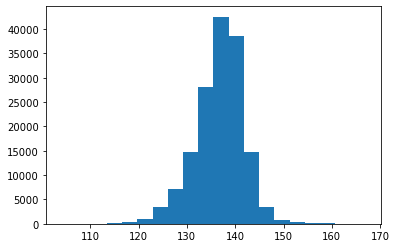

In [90]:
plt.hist(sodium_result['value_source_value'], bins=20)

## Compute MELD

Join tables.

In [91]:
cirrhosis_result = pd.merge(cirrhosis_result,
                            creatinine_result[['person_id', 'measurement_DATE', 'value_source_value']],
                            left_on=['person_id', 'condition_start_DATE'], 
                            right_on=['person_id', 'measurement_DATE'],
                            how='inner')

cirrhosis_result = cirrhosis_result.drop_duplicates()
cirrhosis_result = cirrhosis_result.drop(columns='measurement_DATE')
cirrhosis_result = cirrhosis_result.rename(columns={"value_source_value": "creatinine_mg_dl"})
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl
0,3090170,4340394,2020-02-25,None,8507,1996-07-04,38003563,23,0.68
5,4334906,4046123,2020-10-12,None,8507,1954-12-01,38003563,65,1.04
10,2659536,4046123,2017-11-13,None,8507,1986-01-31,38003563,31,1.95
14,2659536,4064161,2017-11-13,None,8507,1986-01-31,38003563,31,1.95
17,1963756,4046123,2021-01-07,None,8532,1972-01-28,8527,48,1.06
...,...,...,...,...,...,...,...,...,...
101660,1845831,192675,2010-03-25,None,8507,1970-12-23,8515,39,0.70
101661,1988206,192675,2012-06-11,None,8532,1973-02-26,38003563,39,1.30
101662,1235452,192675,2013-05-29,None,8532,1958-07-29,8527,54,0.60
101663,713456,192675,2013-12-30,None,8532,1947-08-22,8527,66,0.60


In [92]:
cirrhosis_result = pd.merge(cirrhosis_result,
                            bilirubin_result[['person_id', 'measurement_DATE', 'value_source_value']],
                            left_on=['person_id', 'condition_start_DATE'], 
                            right_on=['person_id', 'measurement_DATE'],
                            how='inner')

cirrhosis_result = cirrhosis_result.drop_duplicates()
cirrhosis_result = cirrhosis_result.drop(columns='measurement_DATE')
cirrhosis_result = cirrhosis_result.rename(columns={"value_source_value": "bilirubin_mg_dl"})
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl
0,3090170,4340394,2020-02-25,None,8507,1996-07-04,38003563,23,0.68,0.2
1,4334906,4046123,2020-10-12,None,8507,1954-12-01,38003563,65,1.04,1.0
2,2659536,4046123,2017-11-13,None,8507,1986-01-31,38003563,31,1.95,21.1
3,2659536,4064161,2017-11-13,None,8507,1986-01-31,38003563,31,1.95,21.1
4,1963756,4046123,2021-01-07,None,8532,1972-01-28,8527,48,1.06,4.4
...,...,...,...,...,...,...,...,...,...,...
50629,2797317,192675,2011-04-30,None,8532,1989-09-11,8527,21,0.90,0.9
50630,1153575,192675,2011-01-30,None,8532,1957-03-28,8515,53,2.10,37.7
50631,1845831,192675,2010-03-25,None,8507,1970-12-23,8515,39,0.70,4.2
50632,1988206,192675,2012-06-11,None,8532,1973-02-26,38003563,39,1.30,39.0


In [93]:
cirrhosis_result = pd.merge(cirrhosis_result,
                            inr_result[['person_id', 'measurement_DATE', 'value_source_value']],
                            left_on=['person_id', 'condition_start_DATE'], 
                            right_on=['person_id', 'measurement_DATE'],
                            how='inner')

cirrhosis_result = cirrhosis_result.drop_duplicates()
cirrhosis_result = cirrhosis_result.drop(columns='measurement_DATE')
cirrhosis_result = cirrhosis_result.rename(columns={"value_source_value": "INR"})
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR
0,1963756,4046123,2019-06-03,None,8532,1972-01-28,8527,47,1.12,2.1,1.1
1,710763,43531723,2013-08-06,2013-08-06,8532,1947-07-22,38003563,66,0.90,0.5,1.3
2,694553,43531723,2013-10-20,2013-10-20,8507,1947-04-12,8516,66,2.50,7.4,1.8
3,283281,43531723,2012-11-20,2012-11-20,8532,1932-01-13,8515,80,1.40,1.4,1.6
4,922573,4046123,2020-12-04,None,8532,1952-04-11,38003563,68,0.65,0.4,1.1
...,...,...,...,...,...,...,...,...,...,...,...
23983,2797317,192675,2011-04-30,None,8532,1989-09-11,8527,21,0.90,0.9,1.1
23984,1153575,192675,2011-01-30,None,8532,1957-03-28,8515,53,2.10,37.7,2.0
23985,1845831,192675,2010-03-25,None,8507,1970-12-23,8515,39,0.70,4.2,1.3
23986,1988206,192675,2012-06-11,None,8532,1973-02-26,38003563,39,1.30,39.0,1.8


In [94]:
cirrhosis_result = pd.merge(cirrhosis_result,
                            sodium_result[['person_id', 'measurement_DATE', 'value_source_value']],
                            left_on=['person_id', 'condition_start_DATE'], 
                            right_on=['person_id', 'measurement_DATE'],
                            how='inner')

cirrhosis_result = cirrhosis_result.drop_duplicates()
cirrhosis_result = cirrhosis_result.drop(columns='measurement_DATE')
cirrhosis_result = cirrhosis_result.rename(columns={"value_source_value": "sodium_mmol_l"})
cirrhosis_result

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l
0,1963756,4046123,2019-06-03,None,8532,1972-01-28,8527,47,1.12,2.1,1.1,140
1,922573,4046123,2020-12-04,None,8532,1952-04-11,38003563,68,0.65,0.4,1.1,129
2,1253558,4046123,2020-05-13,None,8532,1959-06-23,38003563,60,0.85,1.2,1.2,132
3,1253558,4064161,2020-05-13,None,8532,1959-06-23,38003563,60,0.85,1.2,1.2,132
4,1636838,196463,2019-03-15,None,8507,1966-01-16,38003563,53,0.63,1.2,1.3,139
...,...,...,...,...,...,...,...,...,...,...,...,...
1407,365626,192675,2018-01-23,None,8532,1936-04-29,8515,81,0.69,0.9,1.1,138
1408,365626,192675,2017-08-01,None,8532,1936-04-29,8515,81,0.82,0.8,1.1,139
1409,365626,192675,2017-09-19,None,8532,1936-04-29,8515,81,0.94,0.7,1.1,142
1410,1544830,192675,2017-02-07,None,8507,1964-01-26,38003563,53,0.49,0.8,1.0,139


In [95]:
def meld(person_id, condition_start_DATE, creatinine_mg_dl, bilirubin_mg_dl, INR, sodium_mmol_l):
    # Laboratory values less than 1.0 will be set to 1.0 when calculating a candidate’s MELD score.
    if creatinine_mg_dl < 1.0:
        creatinine_mg_dl = 1.0
    if bilirubin_mg_dl < 1.0:
        bilirubin_mg_dl = 1.0
    if INR < 1.0:
        INR = 1.0
        
    # Sodium values less than 125 mmol/L will be set to 125, and values greater than 137 mmol/L will be set to 137.
    if sodium_mmol_l < 125:
        sodium_mmol_l = 125
    if sodium_mmol_l > 137:
        sodium_mmol_l = 137

    # The following candidates will receive a creatinine value of 4.0 mg/dL:
    ## Candidates with a creatinine value greater than 4.0 mg/dL
    if creatinine_mg_dl > 4.0:
        creatinine_mg_dl = 4.0
    else:
        ## Candidates who received two or more dialysis treatments within the prior 7 days
        match = dialysis_result.query('person_id == @person_id')
        if not match.empty:
            count = 0
            for _, row in match.iterrows():
                if row['procedure_DATE'] < condition_start_DATE:
                    days = relativedelta(condition_start_DATE, row['procedure_DATE']).days
                    if days <= 7:
                        count += 1
            if count >= 2:
                creatinine_mg_dl = 4.0

        ## Candidates who received 24 hours of continuous veno-venous hemodialysis (CVVHD) within the prior 7 days
        # NOTE: No CVVHD records in the dataset.

    meld_initial = 0.957 * np.log(creatinine_mg_dl) + 0.378 * np.log(bilirubin_mg_dl) + 1.120 * np.log(INR) + 0.643
    meld_initial = round(meld_initial, 1) * 10
    meld_initial = min(meld_initial, 40)
    
    if meld_initial > 11:
        meld = meld_initial + 1.32 * (137 - sodium_mmol_l) - (0.033 * meld_initial * (137 - sodium_mmol_l))
    else:
        meld = meld_initial
        
    return meld

cirrhosis_result['meld'] = cirrhosis_result.swifter.progress_bar(True).apply(
    lambda row: meld(row['person_id'], row['condition_start_DATE'], row['creatinine_mg_dl'], row['bilirubin_mg_dl'], row['INR'], row['sodium_mmol_l']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [96]:
cirrhosis_result['meld'].describe()

count    1412.000000
mean       11.905345
std         6.089287
min         6.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        38.792000
Name: meld, dtype: float64

(array([373., 309., 130., 135.,  97.,  52.,  73.,  39.,  33.,  57.,  38.,
         29.,  11.,   8.,  15.,   2.,   5.,   1.,   2.,   3.]),
 array([ 6.    ,  7.6396,  9.2792, 10.9188, 12.5584, 14.198 , 15.8376,
        17.4772, 19.1168, 20.7564, 22.396 , 24.0356, 25.6752, 27.3148,
        28.9544, 30.594 , 32.2336, 33.8732, 35.5128, 37.1524, 38.792 ]),
 <BarContainer object of 20 artists>)

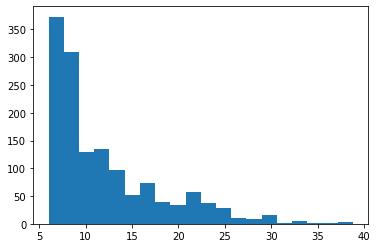

In [97]:
plt.hist(cirrhosis_result['meld'], bins=20)

Observe MELD score distribution across race.

In [98]:
reduced_race_map = {
    8515: 'Asian', 
    8516: 'Black', 
    8527: 'White', 
    38003563: 'Hispanic'
}

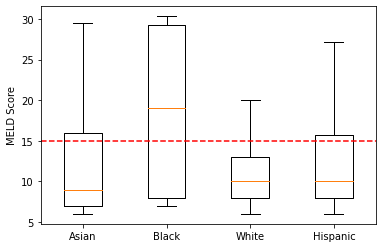

In [99]:
race_meld = []

for race_concept_id in reduced_race_map.keys():
    race_meld.append(cirrhosis_result.loc[cirrhosis_result['race_concept_id'] == race_concept_id, 'meld'])
    
plt.boxplot(race_meld, labels=reduced_race_map.values(), sym='')
plt.ylabel('MELD Score')
plt.axhline(y=15, linestyle='--', color='r')

Observe MELD score distribution across gender.

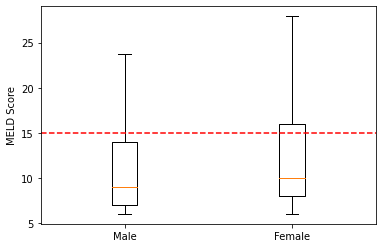

In [100]:
gender_meld = []

for gender_concept_id in reversed(gender_map.keys()):
    gender_meld.append(cirrhosis_result.loc[cirrhosis_result['gender_concept_id'] == gender_concept_id, 'meld'])
    
plt.boxplot(gender_meld, labels=list(reversed(gender_map.values())), sym='')
plt.ylabel('MELD Score')
plt.axhline(y=15, linestyle='--', color='r')

## Obtain Cohort Statistics

In [101]:
cirrhosis_result.groupby('race_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld
race_concept_id,,,,,,,,,,,,
8515,385,385,385,2,385,385,385,385,385,385,385,385
8516,33,33,33,0,33,33,33,33,33,33,33,33
8527,513,513,513,3,513,513,513,513,513,513,513,513
8557,23,23,23,0,23,23,23,23,23,23,23,23
8657,3,3,3,0,3,3,3,3,3,3,3,3
38003563,455,455,455,8,455,455,455,455,455,455,455,455


In [102]:
cirrhosis_result.groupby('gender_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld
gender_concept_id,,,,,,,,,,,,
8507,863,863,863,7,863,863,863,863,863,863,863,863
8532,549,549,549,6,549,549,549,549,549,549,549,549


In [103]:
cirrhosis_result['age_years'].describe()

count    1412.000000
mean       63.326487
std        11.628995
min        16.000000
25%        56.000000
50%        64.000000
75%        71.000000
max        94.000000
Name: age_years, dtype: float64

In [104]:
cirrhosis_result['creatinine_mg_dl'].describe()

count    1412.000000
mean        1.263973
std         1.491439
min         0.280000
25%         0.680000
50%         0.840000
75%         1.110000
max        10.900000
Name: creatinine_mg_dl, dtype: float64

In [105]:
cirrhosis_result['bilirubin_mg_dl'].describe()

count    1412.000000
mean        1.740793
std         2.476413
min         0.200000
25%         0.700000
50%         1.100000
75%         1.900000
max        49.200000
Name: bilirubin_mg_dl, dtype: float64

In [106]:
cirrhosis_result['INR'].describe()

count    1412.000000
mean        1.227833
std         0.329611
min         0.900000
25%         1.100000
50%         1.100000
75%         1.300000
max         5.000000
Name: INR, dtype: float64

In [107]:
cirrhosis_result['sodium_mmol_l'].describe()

count    1412.000000
mean      137.828612
std         4.265840
min       114.000000
25%       136.000000
50%       138.500000
75%       141.000000
max       149.000000
Name: sodium_mmol_l, dtype: float64

## Survival Analysis

### Create Survival Table

In [108]:
def death_event(person_id, condition_start_DATE):
    # MELD predicts survival over a 90 day period.
    time_window = datetime.timedelta(days=90)
    
    # Did the patient die?
    match = death_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['death_DATE'] >= condition_start_DATE and \
               row['death_DATE'] < condition_start_DATE + time_window:
                return pd.Series([row['death_DATE'], None])
    
    # No death record.
    # Patient is censored at the end of the window.
    return pd.Series([None, condition_start_DATE + time_window])
    
cirrhosis_result[['death_DATE', 'censure_DATE']] = cirrhosis_result.swifter.progress_bar(True).apply(
    lambda row: death_event(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [109]:
cirrhosis_result['T'], cirrhosis_result['E'] = lifelines.utils.datetimes_to_durations(start_times=cirrhosis_result['condition_start_DATE'],
                                                                                      end_times=cirrhosis_result['death_DATE'],
                                                                                      fill_date=cirrhosis_result['censure_DATE'])

In [110]:
cirrhosis_result.groupby('T').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld,death_DATE,censure_DATE,E
T,,,,,,,,,,,,,,,,
0.0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1
1.0,3,3,3,0,3,3,3,3,3,3,3,3,3,3,0,3
2.0,2,2,2,0,2,2,2,2,2,2,2,2,2,2,0,2
4.0,2,2,2,0,2,2,2,2,2,2,2,2,2,2,0,2
9.0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1
10.0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1
12.0,3,3,3,0,3,3,3,3,3,3,3,3,3,3,0,3
13.0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1
14.0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1


### Study MELD Concordance

In [111]:
# Compute confidence interval using bootstrap method.
def bootstrap_ci(group, stat_fn):
    bootstraps = 1000
    alpha = 95
    
    # Obtain a population of statistics.
    stats = []
    for i in range(bootstraps):
        sample = group.sample(frac=1, replace=True)  # Sample with replacement.
        stat = stat_fn(sample)
        if stat is None:
            continue
        else:
            stats.append(stat)
    mean = np.mean(stats)
    
    # Calculate confidence interval.
    ordered = np.sort(stats)
    lower = np.percentile(ordered, (100 - alpha) / 2)
    upper = np.percentile(ordered, alpha + ((100 - alpha) / 2))
    
    return (mean, lower, upper)

In [112]:
def compute_concordance(group):
    try:
        return lifelines.utils.concordance_index(group['T'], -group['meld'], group['E'])
    except:
        return None

In [113]:
(c, lower, upper) = bootstrap_ci(cirrhosis_result, compute_concordance)
print("c: {:.2f} (CI: {:.2f}~{:.2f})".format(c, lower, upper))

c: 0.81 (CI: 0.75~0.86)


In [114]:
# Obtain c-statistic for each race group.
for race, group in cirrhosis_result.groupby('race_concept_id'):
    try:
        (c, lower, upper) = bootstrap_ci(group, compute_concordance)
        print("Race: {}, c: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], c, lower, upper))
    except:
        print("Race: {}, c: N/A".format(race_map[race]))

Race: Asian, c: 0.78 (CI: 0.67~0.88)
Race: Black, c: 0.67 (CI: 0.52~0.84)
Race: White, c: 0.76 (CI: 0.65~0.87)


/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Race: Pacific Islander, c: N/A
Race: Native American, c: 1.00 (CI: 1.00~1.00)
Race: Hispanic, c: 0.86 (CI: 0.76~0.94)


In [115]:
# Obtain c-statistic for each gender.
for gender, group in cirrhosis_result.groupby('gender_concept_id'):
    (c, lower, upper) = bootstrap_ci(group, compute_concordance)
    print("Gender: {}, c: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], c, lower, upper))

Gender: Male, c: 0.82 (CI: 0.73~0.91)
Gender: Female, c: 0.78 (CI: 0.71~0.84)


### Observe Negative Events

In [116]:
def calibration(group):
    total = len(group)
    event = len(group[group['E'] == True])
    return event / total * 100

MELD scores below 15 are not listed for transplant.

In [117]:
meld_defer_threshold = 15
no_listing = cirrhosis_result[cirrhosis_result['meld'] < meld_defer_threshold]

Observe stratification across race.

In [118]:
for race, group in no_listing.groupby('race_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Race: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], ratio, lower, upper))

Race: Asian, percentage: 1.08 (CI: 0.00~2.49)
Race: Black, percentage: 0.00 (CI: 0.00~0.00)
Race: White, percentage: 2.46 (CI: 1.20~4.10)
Race: Pacific Islander, percentage: 0.00 (CI: 0.00~0.00)
Race: Native American, percentage: 0.00 (CI: 0.00~0.00)
Race: Hispanic, percentage: 0.92 (CI: 0.00~2.15)


Observe stratification across gender.

In [119]:
for gender, group in no_listing.groupby('gender_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Gender: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], ratio, lower, upper))

Gender: Male, percentage: 1.17 (CI: 0.45~1.93)
Gender: Female, percentage: 2.06 (CI: 0.78~3.64)


Obtain raw negative event counts.

In [120]:
no_listing.groupby('race_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld,death_DATE,censure_DATE,T,E
race_concept_id,,,,,,,,,,,,,,,,
8515,281,281,281,2,281,281,281,281,281,281,281,281,3,278,281,281
8516,15,15,15,0,15,15,15,15,15,15,15,15,0,15,15,15
8527,415,415,415,3,415,415,415,415,415,415,415,415,10,405,415,415
8557,18,18,18,0,18,18,18,18,18,18,18,18,0,18,18,18
8657,2,2,2,0,2,2,2,2,2,2,2,2,0,2,2,2
38003563,326,326,326,6,326,326,326,326,326,326,326,326,3,323,326,326


In [121]:
no_listing.groupby('gender_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld,death_DATE,censure_DATE,T,E
gender_concept_id,,,,,,,,,,,,,,,,
8507,672,672,672,5,672,672,672,672,672,672,672,672,8,664,672,672
8532,385,385,385,6,385,385,385,385,385,385,385,385,8,377,385,385


In [122]:
no_listing[no_listing['E'] == True].groupby('race_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,gender_concept_id,birth_DATETIME,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld,death_DATE,censure_DATE,T,E
race_concept_id,,,,,,,,,,,,,,,,
8515,3,3,3,0,3,3,3,3,3,3,3,3,3,0,3,3
8527,10,10,10,0,10,10,10,10,10,10,10,10,10,0,10,10
38003563,3,3,3,0,3,3,3,3,3,3,3,3,3,0,3,3


In [123]:
no_listing[no_listing['E'] == True].groupby('gender_concept_id').count()

,person_id,condition_concept_id,condition_start_DATE,condition_end_DATE,birth_DATETIME,race_concept_id,age_years,creatinine_mg_dl,bilirubin_mg_dl,INR,sodium_mmol_l,meld,death_DATE,censure_DATE,T,E
gender_concept_id,,,,,,,,,,,,,,,,
8507,8,8,8,0,8,8,8,8,8,8,8,8,8,0,8,8
8532,8,8,8,0,8,8,8,8,8,8,8,8,8,0,8,8


## Logistic Regression

Conduct logistic regression on primary outcome using race, sex, and other covariates.

First encode categorical variables.

In [124]:
# One-hot encode race_concept_id.
race_concept_id = pd.get_dummies(cirrhosis_result['race_concept_id'], drop_first=True)
race_concept_id = race_concept_id.rename(columns=race_map)

In [125]:
# One-hot encode gender_concept_id.
gender_concept_id = pd.get_dummies(cirrhosis_result['gender_concept_id'], drop_first=True)
gender_concept_id = gender_concept_id.rename(columns=gender_map)

Scale numeric variables.

In [126]:
scaler = StandardScaler()
numeric_columns = ['creatinine_mg_dl', 'bilirubin_mg_dl', 'INR', 'sodium_mmol_l']
X_numeric = cirrhosis_result[numeric_columns]
X_numeric[numeric_columns] = scaler.fit_transform(X_numeric)

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [127]:
X = pd.concat([race_concept_id, gender_concept_id, X_numeric], axis=1)
y = cirrhosis_result['E'].astype(int)

Reserve 80% of the samples for training, the rest for testing.

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Train model.

In [129]:
model = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga')
model.fit(X_train, y_train)

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

Verify model accuracy.

In [130]:
model.score(X_test, y_test)

0.9611307420494699

Observe coefficients.

In [131]:
importance = model.coef_.flatten()
importance

array([ 0.        ,  0.10226154, -0.09691606,  0.        , -0.61107586,
        0.22478534,  0.26445308,  0.16433477,  0.40394837, -0.59258793])

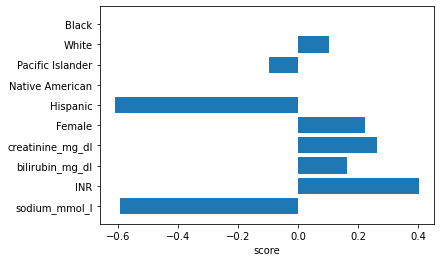

In [132]:
plt.barh(X.columns, importance)
plt.xlabel("score")
plt.gca().invert_yaxis()

In [133]:
model.intercept_

array([-3.67988861])